# Initial Data Load

### load & visualize data

In [1]:
from re import S
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

In [2]:
print("---PRECIPITATION DATA FOR MA---\n")
#load & preprocess data
#change this based on local or in drive, but will always refer to precipitation_data.csv
df = pd.read_csv('precipitation_data.csv')
print(f"Prefiltered length: {len(df)}")
print(df)

---PRECIPITATION DATA FOR MA---

Prefiltered length: 39413
           STATION           STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
1      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
2      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
3      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
4      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
...            ...                    ...        ...       ...        ...   
39408  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39409  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39410  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39411  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39412  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   

                

In [3]:
sns.set(style="whitegrid")
def plot_per_station(df, station, station_name):
    # station_name = dict(zip(df['STATION'], df['STATION_NAME']))

    # for station in df['STATION'].unique():
    station_data = df[df['STATION'] == station]
    station_data['DATE'] = pd.to_datetime(station_data['DATE'], format='%Y%m%d %H:%M')

    fig, axes = plt.subplots(2, 2, figsize=(24, 10))

    # plot 1: precipitation over time
    axes[0, 0].plot(station_data['DATE'], station_data['HPCP'], label=f"Precipitation for {station_name}", color="blue")
    axes[0, 0].set_title(f"Precipitation over Time for {station_name}", fontsize=14)
    axes[0, 0].set_xlabel("Date")
    axes[0, 0].set_ylabel("Precipitation (inches)")
    axes[0, 0].tick_params(axis="x", rotation=45)

    # plot 2: monthly precipitation (seasonal trend)
    station_data['Month'] = station_data['DATE'].dt.month
    monthly_precip = station_data.groupby('Month')['HPCP'].sum()
    axes[0, 1].bar(monthly_precip.index, monthly_precip.values, color="green")
    axes[0, 1].set_title(f"Monthly Precipitation for {station_name}", fontsize=14)
    axes[0, 1].set_xlabel("Month")
    axes[0, 1].set_ylabel("Total Precipitation (inches)")
    axes[0, 1].set_xticks(np.arange(1, 13))

    # Plot 3: Seasonal decomposition using seasonal_decompose
    # Set 'DATE' as index for the seasonal_decompose function
    station_data.set_index('DATE', inplace=True)

    # Use seasonal_decompose for the HPCP column, assuming annual seasonality
    result = seasonal_decompose(station_data['HPCP'], model='additive', period=365)  # period=365 for annual seasonality

    axes[1, 0].plot(result.trend, label="Trend", color='green')
    axes[1, 0].set_title(f"Trend Component for {station_name}")
    axes[1, 0].set_xlabel("Date")
    axes[1, 0].set_ylabel("Precipitation (inches)")

    
     # plot 4: autocorrelation plot
    # autocorrelation helps to see if there are any correlations with previous values (helpful for ARIMA models)
    # fig_acf, ax_acf = plt.subplots(figsize=(10, 6))
    autocorrelation_plot(station_data['HPCP'], axes[1,1])
    # ax_acf.set_title(f"Autocorrelation for {station_name}", fontsize=14)
    
    axes[1, 1].set_title(f"Autocorrelation for {station_name}")
    axes[1,1].set_xlabel("Lag")
    axes[1, 1].set_ylabel("Autocorrelation")

    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    plt.tight_layout()
    plt.show()

/var/folders/7s/7126cfd12hdbvtmddxhwh7x00000gn/T/ipykernel_2292/899182756.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['DATE'] = pd.to_datetime(station_data['DATE'], format='%Y%m%d %H:%M')
/var/folders/7s/7126cfd12hdbvtmddxhwh7x00000gn/T/ipykernel_2292/899182756.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_data['Month'] = station_data['DATE'].dt.month


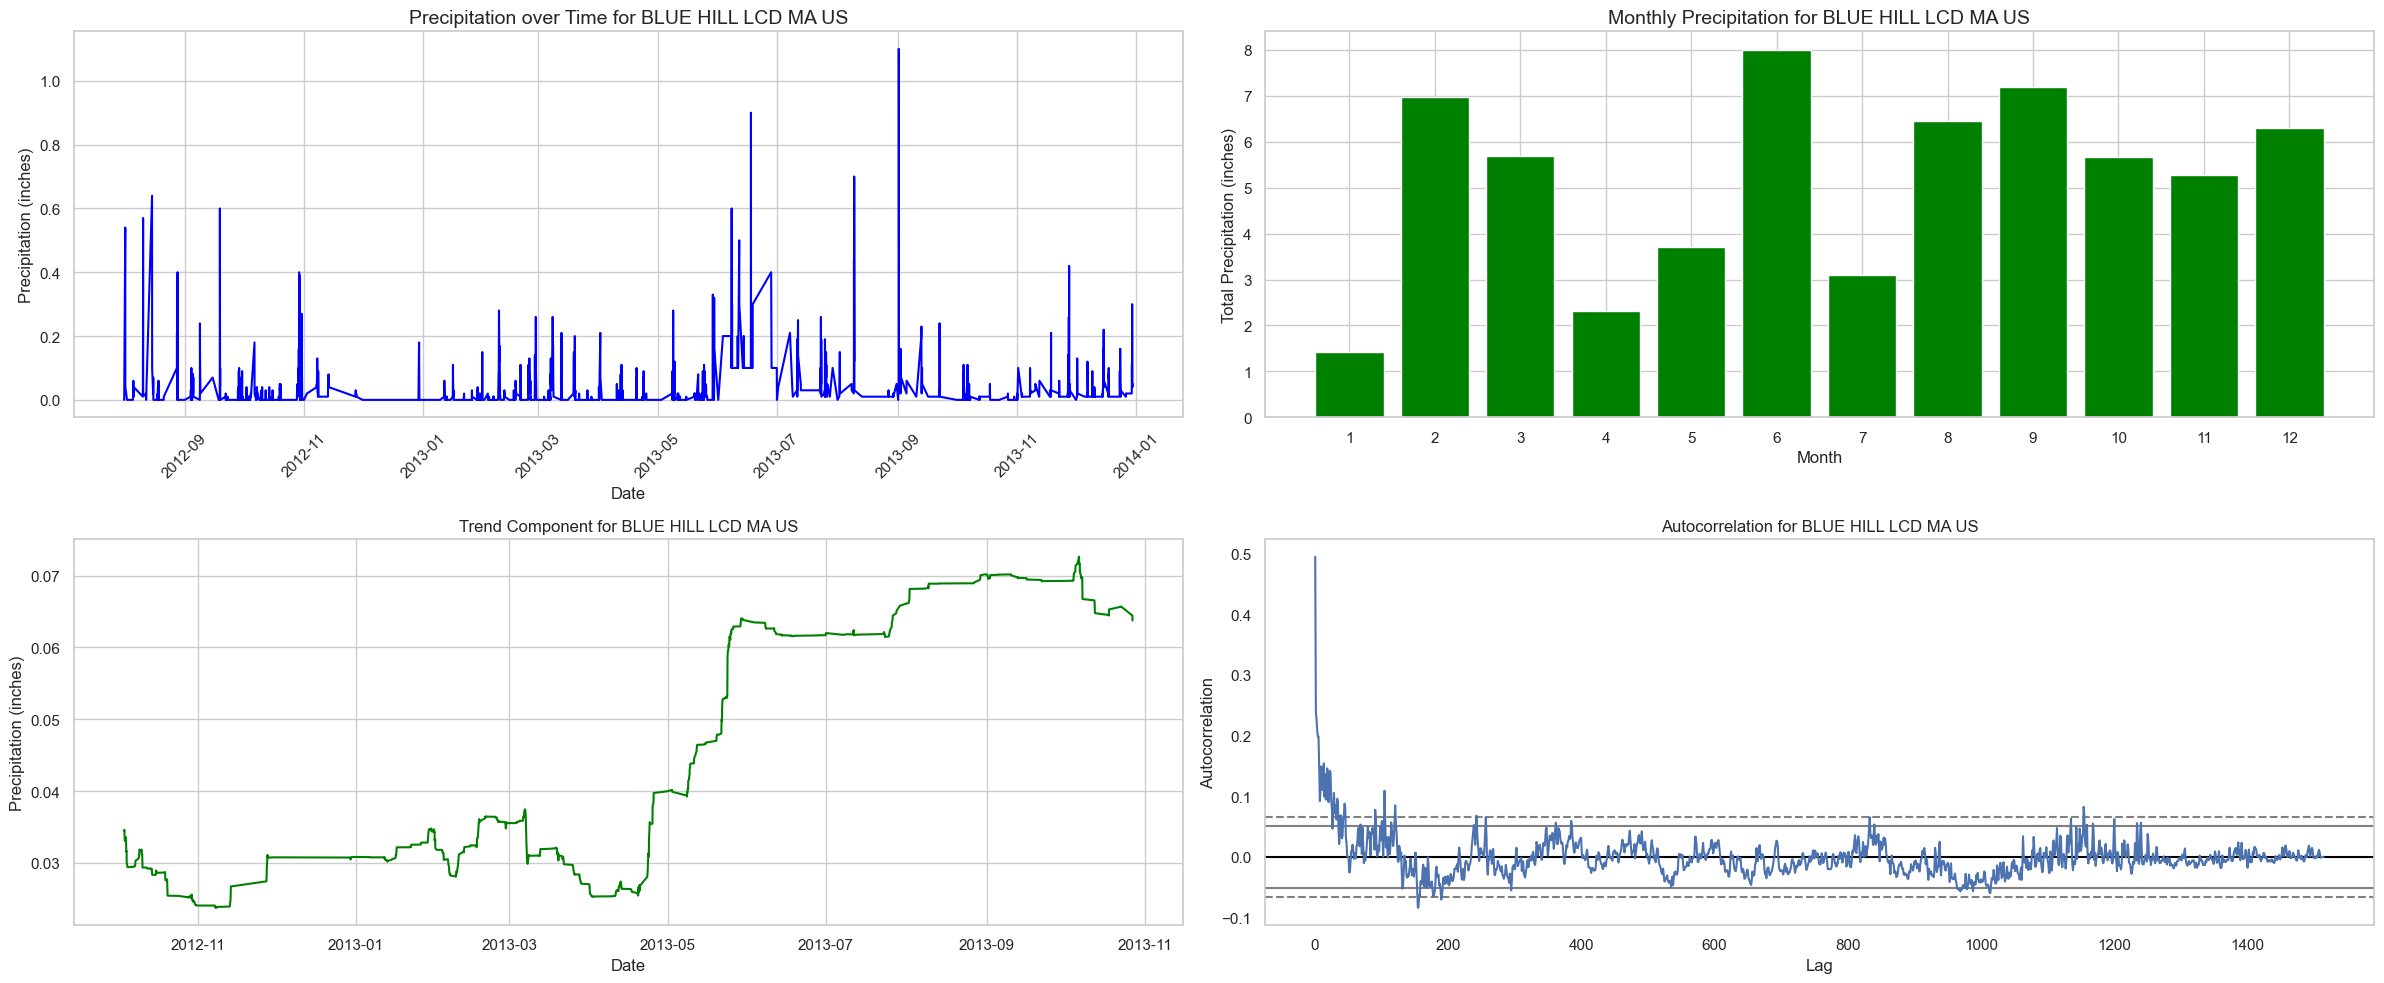

In [4]:
##plot precipitation data
station = "COOP:190737"
station_name = "BLUE HILL LCD MA US"
plot_per_station(df, station, station_name)

## XGBoostClassifier/Preprocess Data

### XGBoost Regression & Classification

In [5]:
def preprocess_for_ml(df):
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d %H:%M')

    #remove missing or invalid data for precipitation
    df['HPCP'] = df['HPCP'].replace(999.99, np.nan)
    df['HPCP'] = df['HPCP'].interpolate(method='linear')
    df = df.dropna(subset=['HPCP'])

    df = df.copy()

    #create additional time-based features
    df.loc[:, 'hour'] = df['DATE'].dt.hour
    df.loc[:, 'day_of_week'] = df['DATE'].dt.dayofweek
    df.loc[:, 'month'] = df['DATE'].dt.month

    #create elevation binning feature(low, med, high)
    bins = [0, 500, 1000, 2000, 3000, np.inf]
    labels = ['0-500m', '500-1000m', '1000-2000m', '2000-3000m', '3000+m']
    df.loc[:, 'elevation_range'] = pd.cut(df['ELEVATION'], bins=bins, labels=labels)


    #drop cols for are not necessary
    df = df.drop(columns=['STATION_NAME', 'Measurement Flag', 'Quality Flag'])

    return df

def add_lag_features(df, lag=1):
    df['HPCP_lag'] = df['HPCP'].shift(lag)
    df = df.dropna()
    return df

In [6]:
# decision tree and XGBoost regression models
def train_regression_models(df, use_elevation=True):
    #select features & target
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['HPCP']

    #split dataset into training & test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    #model 1: decision tree regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    #predict on dataset
    y_pred = dt_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Decision Tree Mean Squared Error: {mse}")

    #model 2: XGBoost Regressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    #predict on dataset
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    print(f"XGBoost Mean Squared Error: {mse_xgb}")


# classification model for heavy rain prediction
def classify_heavy_rain_xgb(df, threshold=0.3, use_elevation=True, with_smote=False, with_class_weights=False):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['heavy_rain']

    X_train_res, X_test, y_train_res, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #apply SMOTE to the training set to balance the classes
    if with_smote:
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_res, y_train_res)

    #class weights
    if with_class_weights:
        scale_pos_weight = (y_train_res == 0).sum() / (y_train_res == 1).sum()
        xgb_class_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)
        xgb_class_model.fit(X_train_res, y_train_res)

    else:
        # Model: XGBoost Classifier
        xgb_class_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
        xgb_class_model.fit(X_train_res, y_train_res)


    y_pred_proba = xgb_class_model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_proba > 0.5).astype(int)  # Apply threshold

    # Evaluate the model
    print(classification_report(y_test, y_pred_class))


In [7]:
#clean data
cleaned_df = preprocess_for_ml(df)
cleaned_df = add_lag_features(cleaned_df)

print(f"Filtered length: {len(cleaned_df)}")
print(cleaned_df)

Filtered length: 39373
           STATION  ELEVATION  LATITUDE  LONGITUDE                DATE  HPCP  \
40     COOP:190737      190.5   42.2123   -71.1137 2012-08-01 02:00:00  0.00   
41     COOP:190737      190.5   42.2123   -71.1137 2012-08-01 15:00:00  0.54   
42     COOP:190737      190.5   42.2123   -71.1137 2012-08-01 16:00:00  0.04   
43     COOP:190737      190.5   42.2123   -71.1137 2012-08-02 13:00:00  0.00   
44     COOP:190737      190.5   42.2123   -71.1137 2012-08-05 13:00:00  0.00   
...            ...        ...       ...        ...                 ...   ...   
39408  COOP:190736      190.5   42.2123   -71.1137 2012-06-26 13:00:00  0.00   
39409  COOP:190736      190.5   42.2123   -71.1137 2012-06-26 14:00:00  0.00   
39410  COOP:190736      190.5   42.2123   -71.1137 2012-06-27 17:00:00  0.00   
39411  COOP:190736      190.5   42.2123   -71.1137 2012-06-29 08:00:00  0.00   
39412  COOP:190736      190.5   42.2123   -71.1137 2012-06-29 10:00:00  0.04   

       hour  day

#### no SMOTE or class weights

In [8]:
## model without elevation
print("MODELING WITHOUT ELEVATION")

print("Training Regression Models...")
train_regression_models(cleaned_df, use_elevation=False)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3, use_elevation=False)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Training Regression Models...
Decision Tree Mean Squared Error: 0.009565545367074326
XGBoost Mean Squared Error: 0.005760223499990786


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7742
           1       0.31      0.08      0.13       133

    accuracy                           0.98      7875
   macro avg       0.64      0.54      0.56      7875
weighted avg       0.97      0.98      0.98      7875

------------------------



In [9]:
## model with elevation
#modeling with elevation feature
print("MODELING WITH ELEVATION")

print("Training Regression Model...")
train_regression_models(cleaned_df)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3)

print("------------------------\n")


MODELING WITH ELEVATION
Training Regression Model...
Decision Tree Mean Squared Error: 0.010358998294265712
XGBoost Mean Squared Error: 0.00567830522404923


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7742
           1       0.26      0.08      0.12       133

    accuracy                           0.98      7875
   macro avg       0.62      0.54      0.55      7875
weighted avg       0.97      0.98      0.98      7875

------------------------



#### SMOTE((Synthetic Minority Over-sampling Technique))

In [10]:
## model without elevation
print("MODELING WITHOUT ELEVATION")

print("Training Regression Models...")
train_regression_models(cleaned_df, use_elevation=False)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3, use_elevation=False, with_smote=True)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Training Regression Models...
Decision Tree Mean Squared Error: 0.009565545367074326
XGBoost Mean Squared Error: 0.005760223499990786


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7742
           1       0.24      0.26      0.25       133

    accuracy                           0.97      7875
   macro avg       0.62      0.62      0.62      7875
weighted avg       0.97      0.97      0.97      7875

------------------------



In [11]:
## model with elevation
#modeling with elevation feature
print("MODELING WITH ELEVATION")

print("Training Regression Model...")
train_regression_models(cleaned_df)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3, with_smote=True)

print("------------------------\n")

MODELING WITH ELEVATION
Training Regression Model...
Decision Tree Mean Squared Error: 0.010358998294265712
XGBoost Mean Squared Error: 0.00567830522404923


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      7742
           1       0.14      0.34      0.20       133

    accuracy                           0.96      7875
   macro avg       0.57      0.65      0.59      7875
weighted avg       0.97      0.96      0.96      7875

------------------------



#### Class weights

In [12]:
## model without elevation
print("MODELING WITHOUT ELEVATION")

print("Training Regression Models...")
train_regression_models(cleaned_df, use_elevation=False)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3, use_elevation=False,  with_class_weights=True)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Training Regression Models...
Decision Tree Mean Squared Error: 0.009565545367074326
XGBoost Mean Squared Error: 0.005760223499990786


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      7742
           1       0.11      0.39      0.17       133

    accuracy                           0.93      7875
   macro avg       0.55      0.67      0.57      7875
weighted avg       0.97      0.93      0.95      7875

------------------------



In [13]:
## model with elevation
#modeling with elevation feature
print("MODELING WITH ELEVATION")

print("Training Regression Model...")
train_regression_models(cleaned_df)

print("\n")

print("Training XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb(cleaned_df, threshold=0.3, with_class_weights=True)

print("------------------------\n")

MODELING WITH ELEVATION
Training Regression Model...
Decision Tree Mean Squared Error: 0.010358998294265712
XGBoost Mean Squared Error: 0.00567830522404923


Training XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      7742
           1       0.11      0.41      0.17       133

    accuracy                           0.93      7875
   macro avg       0.55      0.67      0.57      7875
weighted avg       0.97      0.93      0.95      7875

------------------------



## Random Forest

### Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


# classification model for heavy rain prediction
def classify_heavy_rain_random_forest(df, threshold=0.3, use_elevation=True, with_optimized_params=False):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)

    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['heavy_rain']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #apply SMOTE to the training set to balance the classes
    smote = BorderlineSMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    #use optimized parameters
    if with_optimized_params:
        rf_model = RandomForestClassifier(class_weight='balanced', random_state=42,
                                        max_depth=10, min_samples_leaf=2,
                                        min_samples_split=10, n_estimators=100)
    else:
        rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

    #USED TO FIND BEST parameters
    # param_grid = {
    #     'n_estimators': [100, 200, 300],
    #     'max_depth': [3, 5, 7, 10],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # }
    # grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='precision')
    # grid_search.fit(X_train_res, y_train_res)
    # print("Best hyperparameters:", grid_search.best_params_)
    # rf_model = grid_search.best_estimator_



    rf_model.fit(X_train_res, y_train_res)
    #predict probabilites instead of labels
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

     # Adjust threshold for classifying as heavy rain (class 1)
    y_pred_rf = (y_pred_proba > 0.7).astype(int)
    print(classification_report(y_test, y_pred_rf))


#### without optimized parameters

In [15]:
df = pd.read_csv('precipitation_data.csv')
cleaned_df = preprocess_for_ml(df)
cleaned_df = add_lag_features(cleaned_df)

In [16]:
# #modeling without elevation feature
print("MODELING WITHOUT ELEVATION")

print("Random Forests for Heavy Rain Prediction...")
classify_heavy_rain_random_forest(cleaned_df, threshold=0.3, use_elevation=False)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Random Forests for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7742
           1       0.14      0.04      0.06       133

    accuracy                           0.98      7875
   macro avg       0.56      0.52      0.52      7875
weighted avg       0.97      0.98      0.97      7875

------------------------



In [17]:
 #modeling with elevation feature
print("MODELING WITH ELEVATION")


print("Random Forests for Heavy Rain Prediction...")
classify_heavy_rain_random_forest(cleaned_df, threshold=0.3)

print("------------------------\n")

MODELING WITH ELEVATION
Random Forests for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7742
           1       0.10      0.06      0.08       133

    accuracy                           0.98      7875
   macro avg       0.54      0.53      0.53      7875
weighted avg       0.97      0.98      0.97      7875

------------------------



#### with optimized parameters

In [18]:
# #modeling without elevation feature
print("MODELING WITHOUT ELEVATION")

print("Random Forests for Heavy Rain Prediction...")
classify_heavy_rain_random_forest(cleaned_df, threshold=0.3, use_elevation=False, with_optimized_params=True)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Random Forests for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7742
           1       0.23      0.23      0.23       133

    accuracy                           0.97      7875
   macro avg       0.61      0.61      0.61      7875
weighted avg       0.97      0.97      0.97      7875

------------------------



In [19]:
 #modeling with elevation feature
print("MODELING WITH ELEVATION")


print("Random Forests for Heavy Rain Prediction...")
classify_heavy_rain_random_forest(cleaned_df, threshold=0.3, with_optimized_params=True)

print("------------------------\n")

MODELING WITH ELEVATION
Random Forests for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      7742
           1       0.19      0.30      0.23       133

    accuracy                           0.97      7875
   macro avg       0.59      0.64      0.61      7875
weighted avg       0.97      0.97      0.97      7875

------------------------



## Random Forest Regressor

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Precipitation"):

    diff = np.abs(y_true - y_pred)

    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(y_true, y_pred, c=diff, cmap='coolwarm', alpha=0.6, edgecolors='black')

    plt.colorbar(scatter, label='Absolute Difference')

    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')

    plt.xlabel('Actual Precipitation (HPCP)')
    plt.ylabel('Predicted Precipitation (HPCP)')
    plt.title(title)

    plt.show()

def precipitation_random_forest_regressor(df, use_elevation=True):
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')

    X = df[features]
    y = df['HPCP']  # Predict HPCP, not the binary target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    rf_model = RandomForestRegressor( n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=10,
        bootstrap=True,
        random_state=42)

    #HOW I FOUND the best hyperparameters
    #  param_dist = {
    #     'n_estimators': [100, 200, 300, 500],  # Number of trees
    #     'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    #     'min_samples_split': [2, 5, 10, 20],  # Minimum samples required to split an internal node
    #     'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples required to be at a leaf node
    #     'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for each split
    #     'bootstrap': [True, False]  # Whether to use bootstrap samples for building trees
    # }

    # random_search = RandomizedSearchCV(estimator=rf_model,
    #                                   param_distributions=param_dist,
    #                                   n_iter=50,  # Number of random combinations to sample
    #                                   cv=5,  # 5-fold cross-validation
    #                                   verbose=2,  # Increase verbosity for better insight
    #                                   random_state=42,
    #                                   n_jobs=-1,  # Use all available CPU cores
    #                                   scoring='neg_mean_squared_error')  # Use negative MSE for regression

    # # Fit the RandomizedSearchCV to the training data
    # random_search.fit(X_train, y_train)

    # print("Best hyperparameters found: ", random_search.best_params_)
    # best_rf_model = random_search.best_estimator_


    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    plot_actual_vs_predicted(y_test, y_pred, title="Actual vs Predicted Precipitation")

### with optimized parameters

In [21]:
df = pd.read_csv('precipitation_data.csv')
cleaned_df = preprocess_for_ml(df)
cleaned_df = add_lag_features(cleaned_df)

MODELING WITHOUT ELEVATION
Random Forest Regressor for Precipitation Prediction...
Mean Squared Error: 0.0051929950756639314
R-squared: 0.29940603964280743


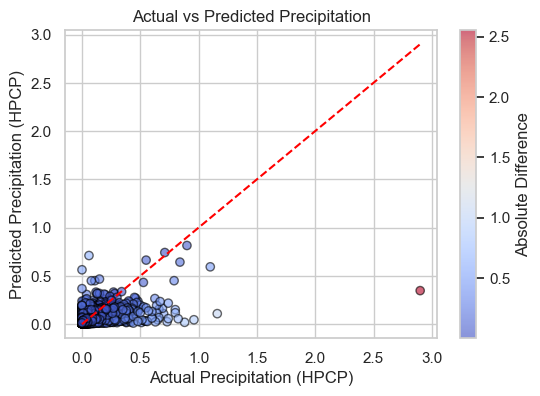

------------------------



In [22]:
 #modeling without elevation feature
print("MODELING WITHOUT ELEVATION")

print("Random Forest Regressor for Precipitation Prediction...")
precipitation_random_forest_regressor(cleaned_df, use_elevation=False)

print("------------------------\n")

MODELING WITH ELEVATION
Random Forest Regressor for Precipitation Prediction...
Mean Squared Error: 0.005212385756624968
R-squared: 0.2967900167560962


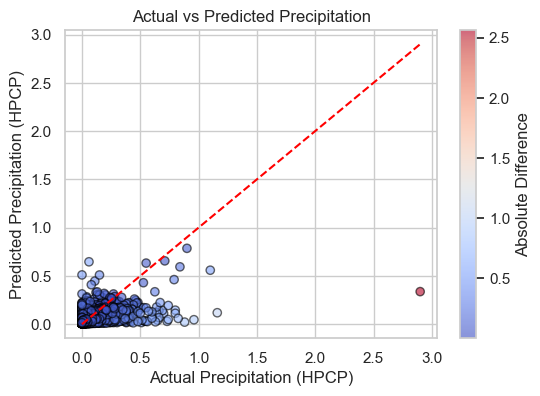

------------------------



In [23]:
#modeling with elevation feature
print("MODELING WITH ELEVATION")


print("Random Forest Regressor for Precipitation Prediction...")
precipitation_random_forest_regressor(cleaned_df)

print("------------------------\n")

# More data

## load new data & merge

In [50]:
import pandas as pd
#new dataset with more information about the weather(i.e. temperature, wind, cloud coverage, etc.)
df = pd.read_csv('2010_weather_MA.csv')
print(df)

           STATION              NAME  LATITUDE  LONGITUDE  ELEVATION  \
0      USW00014739     BOSTON, MA US   42.3606   -71.0097        3.7   
1      USW00014739     BOSTON, MA US   42.3606   -71.0097        3.7   
2      USW00014739     BOSTON, MA US   42.3606   -71.0097        3.7   
3      USW00014739     BOSTON, MA US   42.3606   -71.0097        3.7   
4      USW00014739     BOSTON, MA US   42.3606   -71.0097        3.7   
...            ...               ...       ...        ...        ...   
17513  USW00094746  WORCESTER, MA US   42.2706   -71.8731      304.8   
17514  USW00094746  WORCESTER, MA US   42.2706   -71.8731      304.8   
17515  USW00094746  WORCESTER, MA US   42.2706   -71.8731      304.8   
17516  USW00094746  WORCESTER, MA US   42.2706   -71.8731      304.8   
17517  USW00094746  WORCESTER, MA US   42.2706   -71.8731      304.8   

                 DATE  HLY-CLOD-PCTCLR  HLY-CLOD-PCTOVC  HLY-DEWP-NORMAL  \
0      20100101 01:00            322.0            444.0    

In [51]:
#combine the datasets
df1 = pd.read_csv('2010_weather_MA.csv')
df2 = pd.read_csv('precipitation_data.csv')

#clean df2
cleaned_df = preprocess_for_ml(df2)
cleaned_df = add_lag_features(cleaned_df)

# Convert the 'DATE' column to datetime in both dataframes
df1['DATE'] = pd.to_datetime(df1['DATE'], format='%Y%m%d %H:%M')
cleaned_df['DATE'] = pd.to_datetime(cleaned_df['DATE'], format='%Y%m%d %H:%M')


#the new data has two stations, make the STATION ID uniformed
cleaned_df['STATION'] = cleaned_df['STATION'].replace('COOP:190770', 'USW00014739')
cleaned_df['STATION'] = cleaned_df['STATION'].replace('COOP:199923', 'USW00094746')


combined_df = pd.merge(cleaned_df,df1, on=['STATION','DATE'], how='inner')
combined_df = combined_df.drop(columns=['LONGITUDE_y', 'LATITUDE_y', 'ELEVATION_y'])



In [52]:
combined_df
# combined_df.to_csv('combined_weather_precipitation.csv')

,STATION,ELEVATION_x,LATITUDE_x,LONGITUDE_x,DATE,HPCP,hour,day_of_week,month,elevation_range,HPCP_lag,NAME,HLY-CLOD-PCTCLR,HLY-CLOD-PCTOVC,HLY-DEWP-NORMAL,HLY-HIDX-NORMAL,HLY-TEMP-NORMAL,HLY-WIND-AVGSPD,HLY-WIND-VCTDIR,HLY-WIND-VCTSPD
0,USW00094746,304.8,42.27060,-71.87310,2010-01-01 01:00:00,0.0,1,4,1,0-500m,0.0,"WORCESTER, MA US",NaN,NaN,16.9,25.2,25.2,11.0,283.0,7.2
1,USW00094746,304.8,42.27060,-71.87310,2010-01-01 02:00:00,0.0,2,4,1,0-500m,0.0,"WORCESTER, MA US",NaN,NaN,17.1,25.0,25.0,10.7,282.0,6.8
2,USW00094746,304.8,42.27060,-71.87310,2010-01-01 03:00:00,0.0,3,4,1,0-500m,0.0,"WORCESTER, MA US",NaN,NaN,16.8,24.8,24.8,10.7,283.0,6.7
3,USW00094746,304.8,42.27060,-71.87310,2010-01-01 04:00:00,0.0,4,4,1,0-500m,0.0,"WORCESTER, MA US",NaN,NaN,16.6,24.6,24.6,10.8,285.0,6.7
4,USW00094746,304.8,42.27060,-71.87310,2010-01-01 23:00:00,0.0,23,4,1,0-500m,0.0,"WORCESTER, MA US",NaN,NaN,16.7,25.4,25.4,10.9,284.0,7.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,USW00014739,3.2,42.36057,-71.00975,2010-12-27 11:00:00,0.0,11,0,12,0-500m,0.0,"BOSTON, MA US",122.0,463.0,21.0,34.2,34.2,13.2,287.0,7.6
2818,USW00014739,3.2,42.36057,-71.00975,2010-12-27 12:00:00,0.0,12,0,12,0-500m,0.0,"BOSTON, MA US",126.0,454.0,21.2,35.4,35.4,13.3,285.0,7.6
2819,USW00014739,3.2,42.36057,-71.00975,2010-12-27 13:00:00,0.0,13,0,12,0-500m,0.0,"BOSTON, MA US",106.0,481.0,21.4,36.2,36.2,13.5,282.0,7.5
2820,USW00014739,3.2,42.36057,-71.00975,2010-12-27 14:00:00,0.0,14,0,12,0-500m,0.0,"BOSTON, MA US",110.0,464.0,21.2,36.7,36.7,13.5,284.0,7.4


## XGBoost Classifier

In [53]:
#run previous experiments on new data
from sklearn.metrics import confusion_matrix
from sklearn.impute import KNNImputer
### XGBoost
def classify_heavy_rain_xgb_combined(df, threshold=0.3, use_elevation=True):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)
    #added new features
    features = ['LATITUDE_x', 'LONGITUDE_x', 'hour', 'day_of_week', 'month', 'HPCP_lag',	'HLY-DEWP-NORMAL',	'HLY-HIDX-NORMAL',	'HLY-TEMP-NORMAL',	'HLY-WIND-AVGSPD',	'HLY-WIND-VCTDIR',	'HLY-WIND-VCTSPD']
    if use_elevation:
        features.append('ELEVATION_x')
    X = df[features]
    y = df['heavy_rain']

    imputer = KNNImputer(n_neighbors=5)
    df[features] = imputer.fit_transform(df[features])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



    scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])



    # Model: XGBoost Classifier
    xgb_class_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight = scale_pos_weight)
    xgb_class_model.fit(X_train, y_train)


    y_pred_proba = xgb_class_model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_proba > 0.5).astype(int)  # Apply threshold

    # Evaluate the model
    print(classification_report(y_test, y_pred_class))


In [54]:
df = combined_df
print("MODELING WITHOUT ELEVATION")

threshold =0.3
print(f"Heavy rain threshold: >= {threshold}")

classify_heavy_rain_xgb_combined(df, threshold=threshold, use_elevation=False)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Heavy rain threshold: >= 0.3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       834
           1       0.31      0.31      0.31        13

    accuracy                           0.98       847
   macro avg       0.65      0.65      0.65       847
weighted avg       0.98      0.98      0.98       847

------------------------



In [55]:
print("MODELING WITH ELEVATION")

threshold =0.3
print(f"Heavy rain threshold: >= {threshold}")

print("XGBoost Classifier for Heavy Rain Prediction...")
classify_heavy_rain_xgb_combined(df, threshold=threshold)

print("------------------------\n")

MODELING WITH ELEVATION
Heavy rain threshold: >= 0.3
XGBoost Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       834
           1       0.44      0.31      0.36        13

    accuracy                           0.98       847
   macro avg       0.72      0.65      0.68       847
weighted avg       0.98      0.98      0.98       847

------------------------



## Random Forest

### Random Forest Classifier

In [56]:
### Random Forest Classifier(heavy rain or not)
def classify_heavy_rain_random_forest_combined(df, threshold=0.3, use_elevation=True):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)

    features = ['LATITUDE_x', 'LONGITUDE_x', 'hour', 'day_of_week', 'month', 'HPCP_lag',	'HLY-DEWP-NORMAL',	'HLY-HIDX-NORMAL',	'HLY-TEMP-NORMAL',	'HLY-WIND-AVGSPD',	'HLY-WIND-VCTDIR',	'HLY-WIND-VCTSPD']
    if use_elevation:
        features.append('ELEVATION_x')
    X = df[features]
    y = df['heavy_rain']

    imputer = KNNImputer(n_neighbors=5)
    df[features] = imputer.fit_transform(df[features])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    rf_model = RandomForestClassifier(class_weight='balanced', random_state=42,
                                      max_depth=10, min_samples_leaf=2,
                                      min_samples_split=10, n_estimators=100)



    rf_model.fit(X_train, y_train)
    #predict probabilites instead of labels
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

     # Adjust threshold for classifying as heavy rain (class 1)
    y_pred_rf = (y_pred_proba > 0.5).astype(int)
    print(classification_report(y_test, y_pred_rf))




In [59]:
#modeling without elevation feature
print("MODELING WITHOUT ELEVATION")
threshold =0.2
print(f"Heavy rain threshold: >= {threshold}")

print("Random Forest Classifier for Heavy Rain Prediction...")
classify_heavy_rain_random_forest_combined(df, threshold=threshold, use_elevation=False)

print("------------------------\n")

threshold =0.3
print(f"Heavy rain threshold: >= {threshold}")

print("Random Forest Classifier for Heavy Rain Prediction...")
classify_heavy_rain_random_forest_combined(df, threshold=threshold, use_elevation=False)

print("------------------------\n")

MODELING WITHOUT ELEVATION
Heavy rain threshold: >= 0.2
Random Forest Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       817
           1       0.58      0.37      0.45        30

    accuracy                           0.97       847
   macro avg       0.78      0.68      0.72       847
weighted avg       0.96      0.97      0.96       847

------------------------

Heavy rain threshold: >= 0.3
Random Forest Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       834
           1       0.33      0.08      0.12        13

    accuracy                           0.98       847
   macro avg       0.66      0.54      0.56       847
weighted avg       0.98      0.98      0.98       847

------------------------



In [60]:
### Random Forest Classifier(heavy rain or not)

#modeling with elevation feature
print("MODELING WITH ELEVATION")
threshold =0.2
print(f"Heavy rain threshold: >= {threshold}")

print("Random Forest Classifier for Heavy Rain Prediction...")
classify_heavy_rain_random_forest_combined(df, threshold=threshold)

print("------------------------\n")

threshold =0.3
print(f"Heavy rain threshold: >= {threshold}")

print("Random Forest Classifier for Heavy Rain Prediction...")
classify_heavy_rain_random_forest_combined(df, threshold=threshold)

print("------------------------\n")



MODELING WITH ELEVATION
Heavy rain threshold: >= 0.2
Random Forest Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       817
           1       0.55      0.40      0.46        30

    accuracy                           0.97       847
   macro avg       0.76      0.69      0.72       847
weighted avg       0.96      0.97      0.96       847

------------------------

Heavy rain threshold: >= 0.3
Random Forest Classifier for Heavy Rain Prediction...
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       834
           1       0.33      0.08      0.12        13

    accuracy                           0.98       847
   macro avg       0.66      0.54      0.56       847
weighted avg       0.98      0.98      0.98       847

------------------------



### Random Forest Regressor

In [ ]:
### Random Forest Regressor(predicting actual continuous HPCP value)
def precipitation_random_forest_regressor_combined(df, use_elevation=True):
    features = ['LATITUDE_x', 'LONGITUDE_x', 'hour', 'day_of_week', 'month', 'HPCP_lag',	'HLY-DEWP-NORMAL',	'HLY-HIDX-NORMAL',	'HLY-TEMP-NORMAL',	'HLY-WIND-AVGSPD',	'HLY-WIND-VCTDIR',	'HLY-WIND-VCTSPD']
    if use_elevation:
        features.append('ELEVATION_x')

    X = df[features]
    y = df['HPCP']  # Predict HPCP, not the binary target



    imputer = KNNImputer(n_neighbors=5)
    df[features] = imputer.fit_transform(df[features])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


    rf_model = RandomForestRegressor( n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=10,
        bootstrap=True,
        random_state=42)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f'Cross-validation mean MSE: {-cv_scores.mean()}')

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    plot_actual_vs_predicted(y_test, y_pred, title="Actual vs Predicted Precipitation")



MODELING WITH ELEVATION
Random Forest Regressor for Precipitation Prediction...
Cross-validation mean MSE: 0.004965232458793868
Mean Squared Error: 0.006790023385992543
R-squared: 0.24911620872852747


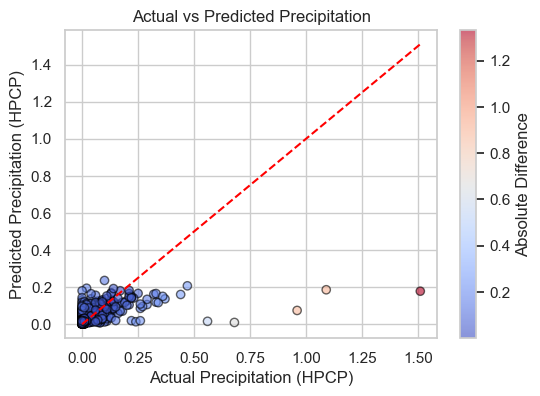

------------------------



In [31]:
### Random Forest Regressor(predicting actual continuous HPCP value)

#modeling with elevation feature
print("MODELING WITH ELEVATION")


print("Random Forest Regressor for Precipitation Prediction...")
precipitation_random_forest_regressor_combined(df)

print("------------------------\n")

# Neural Network


In [32]:
#load weather dataset
weather_df = pd.read_csv('/content/drive/MyDrive/precipitation_data.csv')
weather_df = preprocess_for_ml(weather_df)
weather_df = add_lag_features(weather_df)
weather_df['year'] = weather_df['DATE'].dt.year

# Create binary target column: 1 for heavy rain, 0 otherwise
weather_df['target'] = (weather_df['HPCP'] >= 0.3).astype(int)
num_heavy_weather_events=len(weather_df[weather_df['HPCP'] >= 0.3])
print(f'Number of heavy weather events: {num_heavy_weather_events}')

weather_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/precipitation_data.csv'

In [ ]:
from sklearn.preprocessing import StandardScaler
#continue clean up, drop unnecessary columns
weather_df = weather_df.drop(columns=['DATE', 'HPCP', 'STATION', 'elevation_range'])
continuous_features = ['ELEVATION', 'LATITUDE', 'LONGITUDE']
scaler = StandardScaler()
weather_df[continuous_features] = scaler.fit_transform(weather_df[continuous_features])
weather_df.head()



,ELEVATION,LATITUDE,LONGITUDE,hour,day_of_week,month,HPCP_lag,year,target
40,0.498357,-0.332076,0.323725,2,2,8,0.00,2012,0
41,0.498357,-0.332076,0.323725,15,2,8,0.00,2012,1
42,0.498357,-0.332076,0.323725,16,2,8,0.54,2012,0
43,0.498357,-0.332076,0.323725,13,3,8,0.04,2012,0
44,0.498357,-0.332076,0.323725,13,6,8,0.00,2012,0


In [ ]:
#neural network
import torch
import torch.nn as nn
import torch.nn.functional as F

class WeatherModel(nn.Module):
    def __init__(self, in_features, h1=16, h2=8, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x =  self.out(x)
        return x


#seed, for randomization
torch.manual_seed(32)


In [ ]:
from imblearn.over_sampling import SMOTE

#train test split: set x,y
X = weather_df.drop('target', axis=1)
y= weather_df['target']


#train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=32
                                                    )

smote = SMOTE(sampling_strategy='auto', random_state=32, k_neighbors=7)
X_train, y_train = smote.fit_resample(X_train, y_train)


# convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

w_model = WeatherModel(in_features=X_train.shape[1])


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split

# weights = [1, 5]
# class_weights = torch.FloatTensor(weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(w_model.parameters(), lr=0.001)


losses = []
epochs  = 200
def train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):

        y_pred = model.forward(X_train_tensor)

        loss = criterion(y_pred, y_train_tensor)
        losses.append(loss.detach().numpy())


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



# Train the model
train_model(w_model, X_train_tensor, y_train_tensor, criterion, optimizer, epochs)



Epoch [10/200], Loss: 30.4898
Epoch [20/200], Loss: 11.0604
Epoch [30/200], Loss: 5.0666
Epoch [40/200], Loss: 0.7286
Epoch [50/200], Loss: 0.7224
Epoch [60/200], Loss: 0.9807
Epoch [70/200], Loss: 0.7891
Epoch [80/200], Loss: 0.7213
Epoch [90/200], Loss: 0.7007
Epoch [100/200], Loss: 0.7017
Epoch [110/200], Loss: 0.6946
Epoch [120/200], Loss: 0.6936
Epoch [130/200], Loss: 0.6932
Epoch [140/200], Loss: 0.6925
Epoch [150/200], Loss: 0.6919
Epoch [160/200], Loss: 0.6913
Epoch [170/200], Loss: 0.6908
Epoch [180/200], Loss: 0.6903
Epoch [190/200], Loss: 0.6898
Epoch [200/200], Loss: 0.6893


Text(0.5, 0, 'Epochs')

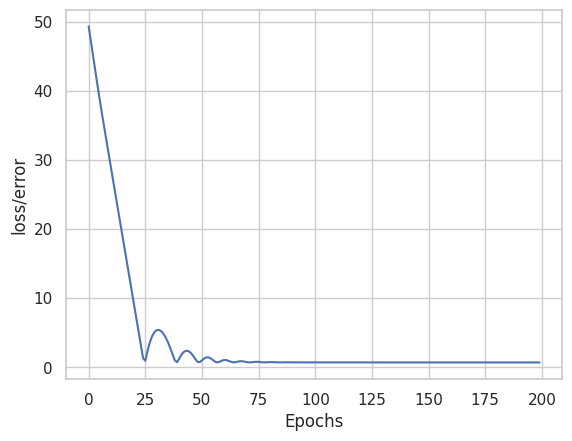

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epochs')

In [ ]:
#evaluate the model on the test data set(validate the model on test set)
with torch.no_grad():
  y_eval = w_model.forward(X_test_tensor) #X_test are features, y_eval will be predictions
  loss = criterion(y_eval, y_test_tensor) #loss or error

loss

tensor(0.6894)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for i,data in enumerate(X_test_tensor):
    y_val = w_model.forward(data)
    #correct or not
    if y_test_tensor[i] == torch.tensor(1):
      total +=1
      # print(f'{i+1}.) true value {y_test_tensor[i]} \t predicted {y_val.argmax()}')
      if y_val.argmax() == y_test_tensor[i]:
        correct +=1
print(f'We got {correct} correct out of {total} for heavy rain events')

We got 107 correct out of 175 for heavy rain events


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


def classification_report_and_confusion_matrix(y_test_tensor, y_pred_class):
    # Convert tensors to numpy for compatibility with sklearn
    y_test_class = y_test_tensor.numpy().flatten()  # Flatten to 1D array
    y_pred_class = y_pred_class.numpy().flatten()  # Flatten to 1D array

    print("\nClassification Report:\n")
    print(classification_report(y_test_class, y_pred_class, target_names=["No Rain/Light Rain", "Heavy Rain"]))

    cm = confusion_matrix(y_test_class, y_pred_class)
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Rain/Light Rain", "Heavy Rain"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

Dataset: larger dataset, precipitation only

Classification Report:

                    precision    recall  f1-score   support

No Rain/Light Rain       0.98      0.54      0.69      7700
        Heavy Rain       0.03      0.61      0.06       175

          accuracy                           0.54      7875
         macro avg       0.51      0.57      0.37      7875
      weighted avg       0.96      0.54      0.68      7875

[[4127 3573]
 [  68  107]]


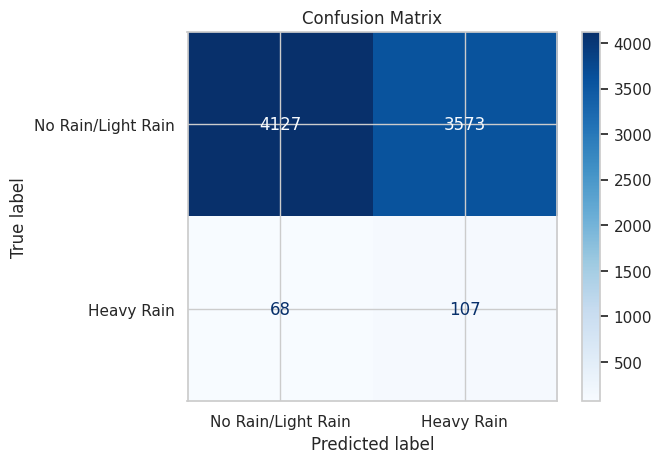

Accuracy on test set: 53.77%
Accuracy for heavy rain events: 61.14%


In [ ]:
# Evaluation function
def evaluate_model(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():

        y_pred = model(X_test_tensor)


        y_pred_class = torch.argmax(y_pred, dim=1)


        classification_report_and_confusion_matrix(y_test_tensor, y_pred_class)

        correct = (y_pred_class == y_test_tensor).sum().item()
        accuracy = correct / y_test_tensor.size(0)

        print(f'Accuracy on test set: {accuracy * 100:.2f}%')

        heavy_rain_mask = (y_test_tensor == 1)
        heavy_rain_correct = (y_pred_class == y_test_tensor) & heavy_rain_mask
        heavy_rain_accuracy = heavy_rain_correct.sum().item() / heavy_rain_mask.sum().item()

        print(f'Accuracy for heavy rain events: {heavy_rain_accuracy * 100:.2f}%')


print("Dataset: larger dataset, precipitation only")
evaluate_model(w_model, X_test_tensor, y_test_tensor)



In [ ]:
#save our NN model
torch.save(w_model.state_dict(), 'heavy_weather_prediction_model.pt')

In [ ]:
#load our model
new_model = WeatherModel(in_features=8)
new_model.load_state_dict(torch.load('heavy_weather_prediction_model.pt'))

<All keys matched successfully>

In [ ]:
#make sure it loaded correctly
new_model.eval()

WeatherModel(
  (fc1): Linear(in_features=8, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=2, bias=True)
)